# Практическая работа №1
## Королев Павел Александрович

# Цель:
изучение архитектуры нейронной сети; создание и
исследование нейронной сети для задачи классификации на языке
Python. 
# Исходные данные:
Набор данных Fashion MNIST. Набор состоит из изображений
одежды размером 28х28. 
Исходная выборка делится на три части: тренировочные
данные, верификационные данные и тестирующие данные
(коэффициент соотношения 6:2:2). 

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

# Вытаскиваю и делю данные

In [2]:
# Создаю набор трансформаций для выгрузки набора данных
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,),)])


# Нормализует по принципу ... среднего и стандартного отклонения?
# А еще преобразует данные в тензор(н-мерную матрицу, в которой данные имеют значения от 0 до 1)

In [3]:
# Скачиваю выборки данных
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data', download=True, train=False, transform=transform)


In [4]:
# Подготовка верификационных данных
indices = list(range(trainset.data.shape[0]))
np.random.shuffle(indices)
# Берем 1/6 данных трейна
split = int(np.floor(0.2 * len(trainset)))
train_sample = SubsetRandomSampler(indices[split:])
valid_sample = SubsetRandomSampler(indices[:split])

In [5]:
# Загрузчики данных для обучающей, верификационной и тестовой выборки
trainloader = torch.utils.data.DataLoader(trainset, sampler=train_sample, batch_size=64)
validloader = torch.utils.data.DataLoader(trainset, sampler=valid_sample, batch_size=64)
testloader = torch.utils.data.DataLoader(testset,batch_size=64, shuffle=True)

Нужны шорты, юбки и ботинки(1, 8 и 9)

In [9]:
# Вытаскиваю только нужные классы одежды из выборок
classes = [1, 8, 9]
batch_size = 64
new_train_set = []
new_valid_set = []
new_test_set = []
new_images = []
new_labels = []
train_len = 0
valid_len = 0
test_len = 0
for images, labels in trainloader:
    for i in range(len(images)): 
        if labels[i] in classes:
            if len(new_labels) < batch_size:
                new_images.append(images[i].tolist())
                new_labels.append(labels[i].tolist())
            else:
                new_tensor = [torch.Tensor(new_images).float()]
                new_tensor.append(torch.Tensor(new_labels).long())
                new_train_set.append(new_tensor)
                new_images = []
                new_labels = []
            train_len +=1
for images, labels in validloader:
    for i in range(len(images)): 
        if labels[i] in classes:
            if len(new_labels) < batch_size:
                new_images.append(images[i].tolist())
                new_labels.append(labels[i].tolist())
            else:
                new_tensor = [torch.Tensor(new_images).float()]
                new_tensor.append(torch.Tensor(new_labels).long())
                new_valid_set.append(new_tensor)
                new_images = []
                new_labels = []
            valid_len +=1
for images, labels in testloader:
    for i in range(len(images)): 
        if labels[i] in classes:
            if len(new_labels) < batch_size:
                new_images.append(images[i].tolist())
                new_labels.append(labels[i].tolist())
            else:
                new_tensor = [torch.Tensor(new_images).float()]
                new_tensor.append(torch.Tensor(new_labels).long())
                new_test_set.append(new_tensor)
                new_images = []
                new_labels = []
            test_len += 1

# Подготовка функционала для работы с моделью

In [10]:
# Функция обучения
def trainer_func(name, classifier, Loss, optimizer, trainloader, validloader, epochs, train_len, valid_len):
    trained_path = 'trained_classifier_' + name + '.pt'
    valid_loss_min = np.Inf 
    steps = 0
    classifier.train()
    train_losses, valid_losses = [], []
    for i in range(epochs):
        running_loss = 0
        valid_loss = 0

        for images, labels in trainloader:
            optimizer.zero_grad()
            log_ps = classifier(images)
            loss = Loss(log_ps, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()*images.size(0)

        for images, labels in validloader:
            log_ps = classifier(images)
            loss = Loss(log_ps, labels)
            valid_loss += loss.item()*images.size(0)

        running_loss = running_loss/train_len
        valid_loss = valid_loss/valid_len
        train_losses.append(running_loss)
        valid_losses.append(valid_loss)

        print("Epoch: {}/{}.. ".format(i+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss),
              "Val Loss: {:.3f}.. ".format(valid_loss))
        if valid_loss <= valid_loss_min:
            print('validation loss decreased({:.6f} -->{:.6f}). Saving Model ...'.format(valid_loss_min, valid_loss))
            torch.save(classifier.state_dict(), trained_path)
            valid_loss_min = valid_loss
    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Valid Loss')

    plt.legend()
    return trained_path

# Функция тестировки
def tester_func(classifier, Loss, testloader, test_len):
    test_loss = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    classifier.eval()
    for images, labels in testloader:
        #forword pass 
        output = classifier(images)
        #calculate the loss
        loss = Loss(output, labels)
        #update the test loss
        test_loss += loss.item()*images.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        #compare predictions to the true labes
        correct = np.squeeze(pred.eq(labels.data.view_as(pred)))
        #calculate test accuracy for each object class
        for i in range(len(labels)):
            label = labels.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] +=1

    #calcaulate and prınt test loss
    test_loss = test_loss/test_len
    print('Test Loss: {:.6f}\n'.format(test_loss))

    for i in range(10):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)'%
                 (str(i), 100 * class_correct[i]/class_total[i],
                 np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A(no training examples)' % classes[i])

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

# Класс нейросети

По сути нейросеть это граф, у которого есть н-ное число слоев(в моем случае входной слой, 6 скрытых слоев и один выходной слой). В каждом слое каждая вершина графа соединяется с каждой вершиной графа в следующем слое(Fully Connected Neural Network, иногда соединяются не все). Соеденияются они с помощью ребер, в нейросетях это связи. Каждая связь перемножает выходные данные нейрона на коэффициент связи. Позже в вершине(в самом нейроне) данные суммируются и преобразуются с помощью некой функции. Потом передаются так же, пока не дойдут до выходного нейрона. Ну а дальше мы выбираем данные с выходного нейрона по наибольшему значению. Напишем ...

In [11]:
class Winner(nn.Module):

    def __init__(self):
        super().__init__()
        n_neurons = [2 ** x for x in range(10, 0, -1)] #Набор степеней двойки
        
        self.fully_connected1 = nn.Linear(28*28, n_neurons[0]) #28 * 28: входной слой, число нейронов - размер изображения
        self.fully_connected2 = nn.Linear(n_neurons[0], n_neurons[1])
        self.fully_connected3 = nn.Linear(n_neurons[1], n_neurons[2])
        self.fully_connected4 = nn.Linear(n_neurons[2], n_neurons[3])
        self.fully_connected5 = nn.Linear(n_neurons[3], n_neurons[4])
        self.fully_connected6 = nn.Linear(n_neurons[4], n_neurons[5])
        self.fully_connected7 = nn.Linear(n_neurons[5], n_neurons[6])
        self.fully_connected8 = nn.Linear(n_neurons[6], 10)

    def forward(self, x):
        # F.relu - Активационная функция релу, сначала равная нулю, потом график прямой под 45 градусов
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fully_connected1(x))
        x = F.relu(self.fully_connected2(x))
        x = F.relu(self.fully_connected3(x))
        x = F.relu(self.fully_connected4(x))
        x = F.relu(self.fully_connected5(x))
        x = F.relu(self.fully_connected6(x))
        x = F.relu(self.fully_connected7(x))
        x = self.fully_connected8(x)
#         F.log_softmax - Активационная функция софтмакса, очень умная, график не понял где найти
        return F.log_softmax(x, dim=1)

Epoch: 1/10..  Training Loss: 0.619..  Val Loss: 0.037.. 
validation loss decreased(inf -->0.036595). Saving Model ...
Epoch: 2/10..  Training Loss: 0.028..  Val Loss: 0.020.. 
validation loss decreased(0.036595 -->0.019622). Saving Model ...
Epoch: 3/10..  Training Loss: 0.020..  Val Loss: 0.017.. 
validation loss decreased(0.019622 -->0.017448). Saving Model ...
Epoch: 4/10..  Training Loss: 0.018..  Val Loss: 0.023.. 
Epoch: 5/10..  Training Loss: 0.014..  Val Loss: 0.021.. 
Epoch: 6/10..  Training Loss: 0.011..  Val Loss: 0.014.. 
validation loss decreased(0.017448 -->0.014375). Saving Model ...
Epoch: 7/10..  Training Loss: 0.017..  Val Loss: 0.020.. 
Epoch: 8/10..  Training Loss: 0.009..  Val Loss: 0.008.. 
validation loss decreased(0.014375 -->0.008429). Saving Model ...
Epoch: 9/10..  Training Loss: 0.006..  Val Loss: 0.018.. 
Epoch: 10/10..  Training Loss: 0.005..  Val Loss: 0.012.. 


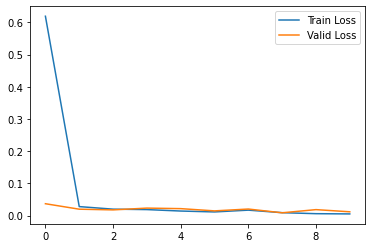

In [13]:
Loss = nn.CrossEntropyLoss()
classifier = Winner()
name = 'winner'
optimizer = optim.SGD(classifier.parameters(), lr=0.05, momentum=0.9)
epochs = 10
trained_path = trainer_func(name, classifier, Loss, optimizer, new_train_set, new_valid_set, epochs, train_len, valid_len)

In [15]:
classifier.load_state_dict(torch.load(trained_path))

<All keys matched successfully>

In [17]:
tester_func(classifier, Loss, testloader, test_len)

Test Loss: 23.942650

Test Accuracy of     0:  0% ( 0/1000)
Test Accuracy of     1: 99% (996/1000)
Test Accuracy of     2:  0% ( 0/1000)
Test Accuracy of     3:  0% ( 0/1000)
Test Accuracy of     4:  0% ( 0/1000)
Test Accuracy of     5:  0% ( 0/1000)
Test Accuracy of     6:  0% ( 0/1000)
Test Accuracy of     7:  0% ( 0/1000)
Test Accuracy of     8: 99% (994/1000)
Test Accuracy of     9: 99% (999/1000)

Test Accuracy (Overall): 29% (2989/10000)
